Pandemic simulation

In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import cv2

In [22]:
class Human:
    virus_state = 0
    virus_days = 0
    age = 30    
    immunity = 1.0

    def __init__(self, virus_state, age, immunity):
        self.virus_state = virus_state
        self.age = age
        self.immunity = immunity


def init_population(x, y):
    
    population = np.ndarray(shape = (x, y), dtype = Human)
    
    for i in range(len(population)):
        for j in range(len(population[i])):
            age = random.randint(1, 80)
            imm = random.gauss(1.0, 0.2) if IMMUNITY else 1
            population[i][j] = Human(0, age, imm) #add correct distribution
            #population[i][j].age = random.randint(1, 80)
            #population[i][j].immunity = random.randint(0, 100)
    
    return population

Virus functions

In [23]:
def start_epidemy(population, n):
    infected = []
    population_count = x_size*y_size
    for h in range(n):
        id = random.randint(0, population_count)
        population[id//x_size][id%y_size].virus_state = 1
        infected.append(id)
    return infected

def spred_virus(population, id, new_infected):
    spread = random.random()
    person = population[id//x_size][id%y_size]
    p = transfer_factor * (2 - person.immunity) #
    if spread < p and person.virus_state == 0:
        population[id//x_size][id%y_size].virus_state = 1
        new_infected.append(id)
        #print ("new virus case")

def random_spread(population, contacts, new_infected):
    i = 0
    while i < contacts:
        id = random.randint(0, x_size*y_size - 1)
        x = id//x_size
        y = id%y_size
        if population[x][y].virus_state == 0:
            spread = random.random()
            p = public_transfer_factor * (2 - population[x][y].immunity) 
            if spread < p:
                population[x][y].virus_state = 1
                new_infected.append(id)
        i += 1

Healing process

In [24]:
def virus_progress (population, id, infected, new_ill):
    x = id//x_size
    y = id%y_size
    if population[x][y].virus_state == 1: #just check
        population[x][y].virus_days += 1
        if population[x][y].virus_days > 7:
            population[x][y].virus_state = 2
            infected.remove(id)
            new_ill.append(id)

def heal(population, id, ill, healed, dead):
    x = id//x_size
    y = id%y_size
    if population[x][y].virus_state == 2: #just check
        death = random.random()
        p =  (2 - population[x][y].immunity) * death_factor
        if death < p:
            population[x][y].virus_state = 4
            ill.remove(id)
            dead.append(id)
        else:
            population[x][y].virus_days += 1
            if population[x][y].virus_days > 15:
                population[x][y].virus_state = 3
                ill.remove(id)
                healed.append(id)

Visual function

In [54]:
def update_view(population, virus_dynamics, video_out = None):   
    virus_img = np.ndarray([x_size, y_size, 3], dtype=np.uint8)
    virus_img[:,:] = [255, 255, 255]
    for i in range(len(virus_img)):
        for j in range(len(virus_img)):
            if population[i][j].virus_state == 0:
                virus_img[i,j,:] = 255
            elif population[i][j].virus_state == 1:
                virus_img[i,j,1:2] = 0
            elif population[i][j].virus_state == 2:
                virus_img[i,j,0:1] = 0
                virus_img[i,j,2] = 255
            elif population[i][j].virus_state == 3:
                virus_img[i,j,0] = 100
                virus_img[i,j,1] = 255
                virus_img[i,j,2] = 100
            elif population[i][j].virus_state == 4:
                virus_img[i,j,:] = 0
        
    if video_out:
        frame = cv2.resize(virus_img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)             
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_out.write(frame)
    if REAL_TIME_PROGRESS:
        plt.imshow(virus_img)
        plt.draw()
        plt.pause(0.001)
    virus_dynamics.append(virus_img)
    return virus_img
    
def age_distribution(population, group = 0):
    ages = []
    if group:    
        for id in group:
            x = id//x_size
            y = id%y_size
            ages.append(population[x][y].age)
    else:
        for x in range(len(population)):
            for y in range(len(population[0])):
                ages.append(population[x][y].age)
    return ages

def immunitet_distribution(population, group = 0):
    immunitys = []
    if group:    
        for id in group:
            x = id//x_size
            y = id%y_size
            immunitys.append(population[x][y].immunity)
    else:
        for x in range(len(population)):
            for y in range(len(population[0])):
                immunitys.append(population[x][y].immunity)
    return immunitys

Virus step

In [55]:
def virus_step(population, infected, ill, healed, dead,
               infected_dynamics, ill_dynamics, healed_dynamics, dead_dynamics,
               virus_dynamics, video_out = 0):
    
    new_ill = []    
    new_infected = []
    for id in infected:
        for i in range(3):
            for j in range(3):
                n_id_x = (id//x_size + (i-1))%x_size
                n_id_y = (id%x_size + j-1)%y_size
                n_id = n_id_x *x_size + n_id_y 
                if id != n_id:
                    spred_virus(population, n_id, new_infected)
        random_spread(population, PUBLIC_TRANSPORT, new_infected)
        virus_progress(population, id, infected, new_ill)

    for id in ill:   
        heal(population, id, ill, healed, dead)
    
    for new_id in new_ill:
        ill.append(new_id)
    for new_id in new_infected:
        infected.append(new_id)

    infected_dynamics.append(len(infected))
    ill_dynamics.append(len(ill))
    healed_dynamics.append(len(healed))
    dead_dynamics.append(len(dead))

    #update picture
    if WRITE_VIDEO:
        update_view(population, virus_dynamics, video_out)

Set world parameters

In [56]:
WRITE_VIDEO = True
REAL_TIME_PROGRESS = False
PUBLIC_TRANSPORT = 50
IMMUNITY = True


x_size = 100
y_size = 100
scale = 5
start_num = 1
transfer_factor = 0.05 #5% transfer chance in case of averege immunity
public_transfer_factor = 0.0005 #0.05% chance to catch virus
death_factor = 0.01 # 1% chance to die particular day

In [28]:
def run(population, virus_dynamics, infected_dynamics, ill_dynamics, healed_dynamics, dead_dynamics):    
    
    infected = start_epidemy(population, start_num)
    ill = []
    dead = []
    healed = []
    
    if WRITE_VIDEO:
        out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (scale * x_size, scale * y_size))

        for step in range(1000):
            print ("step:", step, "; total cases", len(infected) + len(ill) + len(healed) + len (dead),
                   "; number of infected", len(infected),"; number of ill", len(ill), "; healed",len(healed), "; dead", len(dead))
            virus_step(population, 
                       infected, ill, healed, dead,
                       infected_dynamics, ill_dynamics, healed_dynamics, dead_dynamics,
                       virus_dynamics, video_out=out)
            if (len(infected) + len (ill)) == 0:
                break
        out.release()
    
    else: 
        for step in range(500):
            print ("step:", step, "; total cases", len(infected) + len(ill) + len(healed) + len (dead),
                   "; number of infected", len(infected),"; number of ill", len(ill), "; healed",len(healed), "; dead", len(dead))
            virus_step(population,
                       infected, healed, dead,
                       infected_dynamics, healed_dynamics,dead_dynamics,
                       virus_dynamics)
            if (len(infected) + len (ill)) == 0:
                break

    '''            
    with open("infected_dynamics.txt", 'w') as f:
        for x in infected_dynamics:
            f.write(str(x) + '\n')

    with open("healed_dynamics.txt", 'w') as f:
        for x in healed_dynamics:
            f.write(str(x) + '\n')

    with open("dead_dynamics.txt", 'w') as f:
        for x in dead_dynamics:
            f.write(str(x) + '\n')
    '''
    virus_img =  update_view(population, virus_dynamics)
    plt.imsave('final_state.png', virus_img)
    print("Virus pandemic ended!")

    

In [57]:

virus_dynamics = []
infected_dynamics = []
ill_dynamics = []
healed_dynamics = []
dead_dynamics = []

population = init_population(x_size, y_size)

run(population, virus_dynamics, infected_dynamics, ill_dynamics, healed_dynamics, dead_dynamics)


step: 0 ; total cases 1 ; number of infected 1 ; number of ill 0 ; healed 0 ; dead 0
step: 1 ; total cases 1 ; number of infected 1 ; number of ill 0 ; healed 0 ; dead 0
step: 2 ; total cases 2 ; number of infected 2 ; number of ill 0 ; healed 0 ; dead 0
step: 3 ; total cases 4 ; number of infected 4 ; number of ill 0 ; healed 0 ; dead 0
step: 4 ; total cases 5 ; number of infected 5 ; number of ill 0 ; healed 0 ; dead 0
step: 5 ; total cases 7 ; number of infected 7 ; number of ill 0 ; healed 0 ; dead 0
step: 6 ; total cases 8 ; number of infected 8 ; number of ill 0 ; healed 0 ; dead 0
step: 7 ; total cases 9 ; number of infected 9 ; number of ill 0 ; healed 0 ; dead 0
step: 8 ; total cases 11 ; number of infected 10 ; number of ill 1 ; healed 0 ; dead 0
step: 9 ; total cases 15 ; number of infected 14 ; number of ill 1 ; healed 0 ; dead 0
step: 10 ; total cases 19 ; number of infected 18 ; number of ill 1 ; healed 0 ; dead 0
step: 11 ; total cases 21 ; number of infected 18 ; number

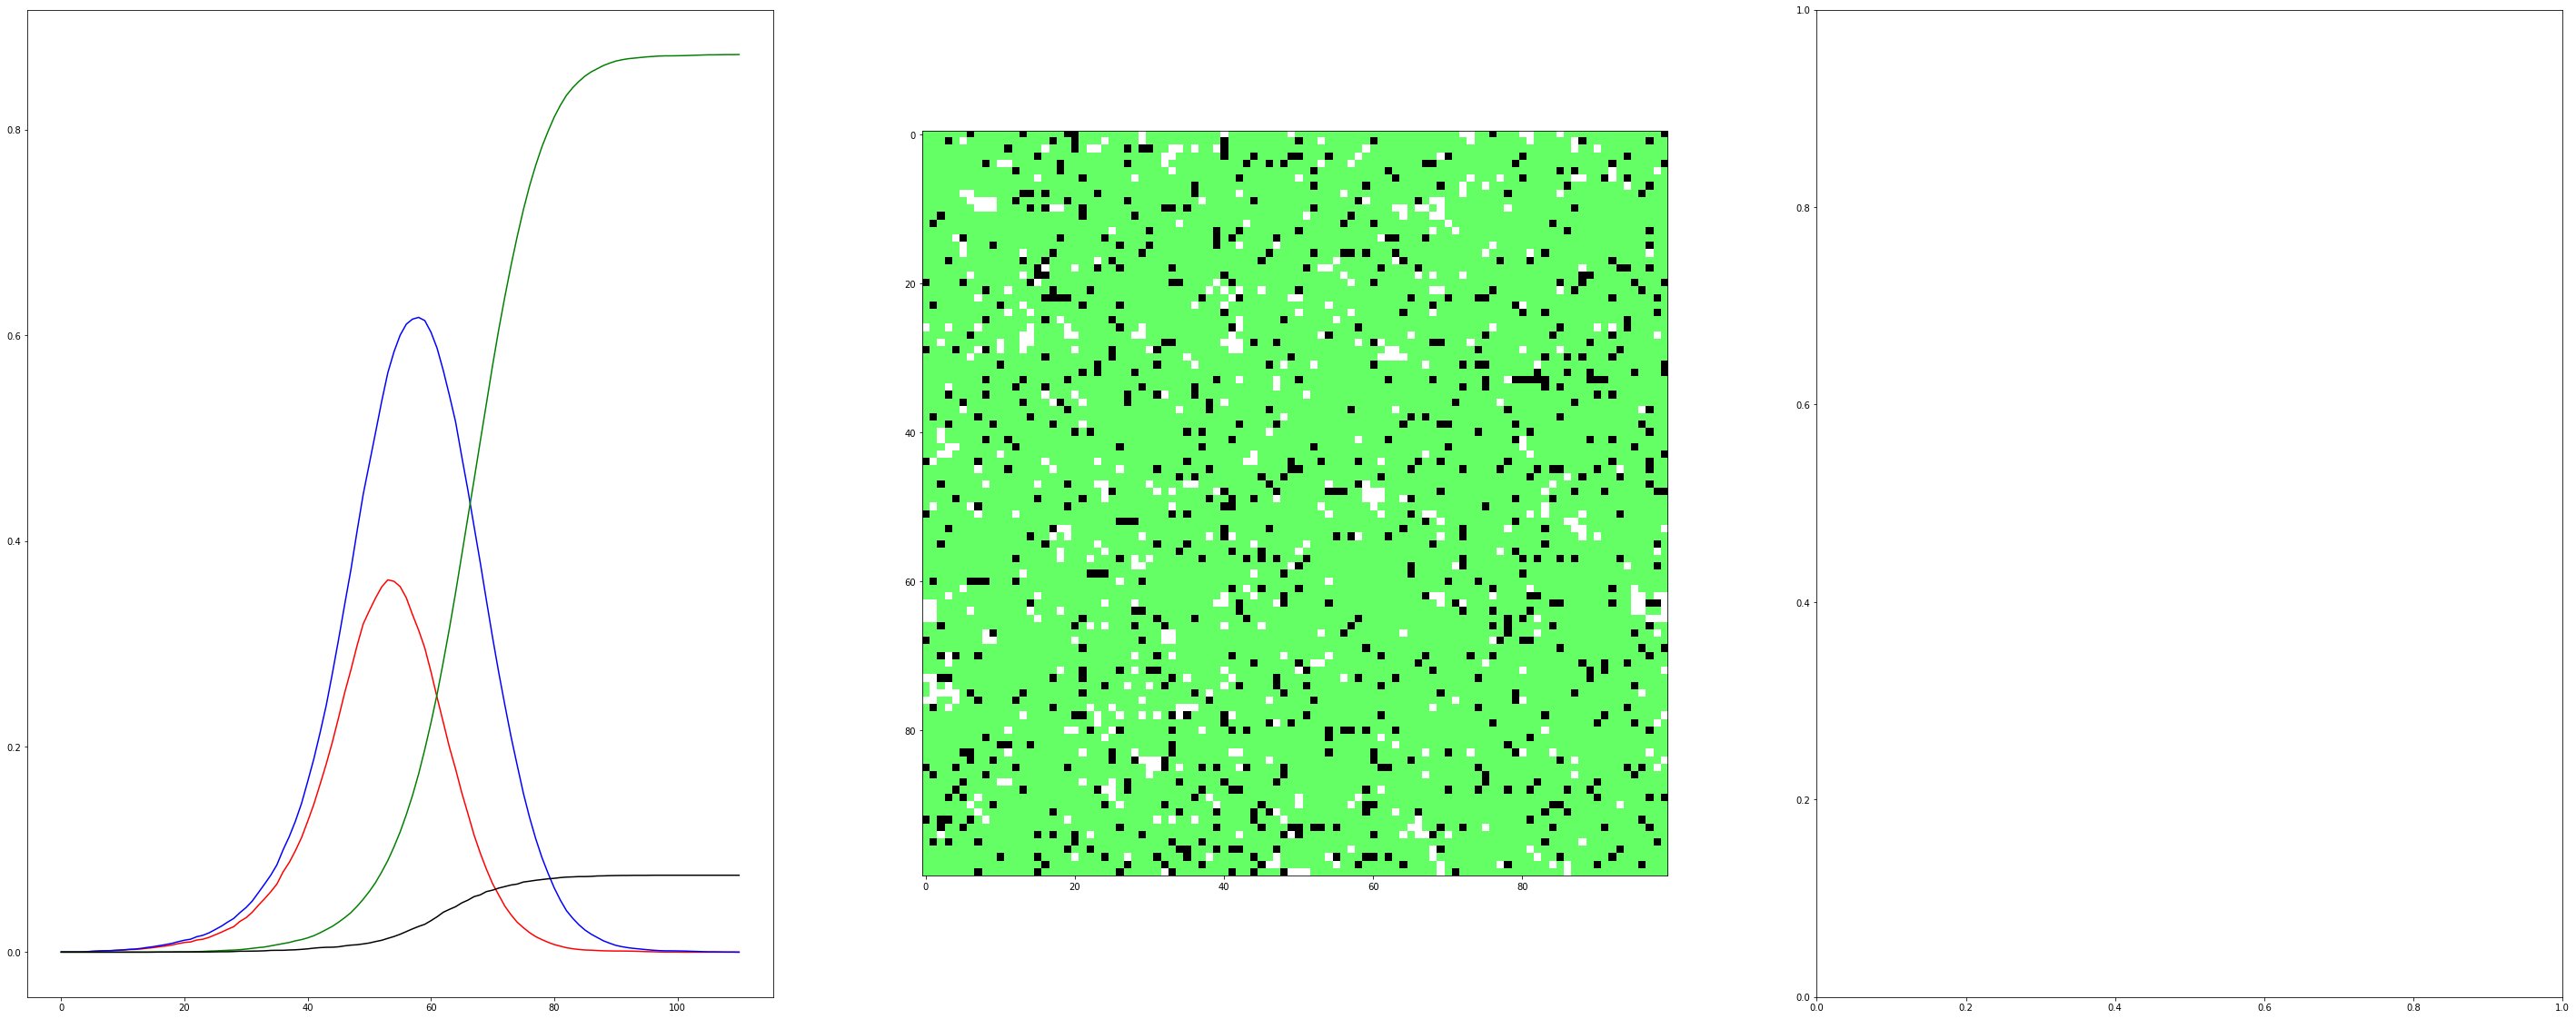

In [30]:
population_size = x_size*y_size

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50,20))

infected_prc = [ i/population_size for i in infected_dynamics]    
ill_prc = [ (infected_dynamics[i] + ill_dynamics[i])/population_size for i in range(len(ill_dynamics))]
healed_prc = [ i/population_size for i in healed_dynamics]
dead_prc = [ i/population_size for i in dead_dynamics]

    
ax1.plot(infected_prc, 'red')
ax1.plot(ill_prc, 'blue')
ax1.plot(healed_prc, 'green')
ax1.plot(dead_prc, 'black')

ax2.imshow(virus_dynamics[-1])

#plt.yscale("log")
#ax3.hist(age_distribution(population), 20, fc=(0, 0, 1, 1.0))
#ax3.hist(age_distribution(population, dead), 20, fc=(1, 0, 0, 0.5))
#plt.show()

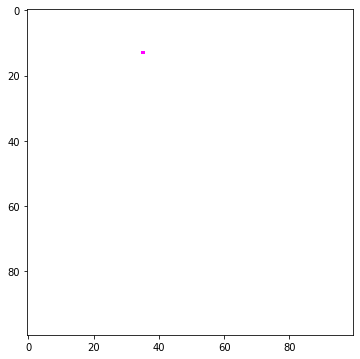

In [67]:
%matplotlib inline
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

fig, ax = plt.subplots(figsize=(6,6))
def animate(i):
    ax.imshow(virus_dynamics[i])
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(virus_dynamics))

In [58]:
print(len(virus_dynamics))

103


In [68]:
ani